# Visualize phylogenetic trees

Import Python packages:

In [1]:
import collections
import itertools
import math
import os

import Bio.SeqIO

import numpy

import pandas as pd

import ete3

/fh/fast/bloom_j/software/miniconda3/envs/ete3/lib/python3.8/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
/fh/fast/bloom_j/software/miniconda3/envs/ete3/lib/python3.8/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


Get variables from `snakemake`:

In [2]:

######## snakemake preamble start (automatically inserted, do not edit) ########
import sys; sys.path.extend(['/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2_PRJNA612766/lib/python3.8/site-packages', '/home/jbloom/SARS-CoV-2_PRJNA612766/notebooks']); import pickle; snakemake = pickle.loads(b"\x80\x04\x95\x8e,\x00\x00\x00\x00\x00\x00\x8c\x10snakemake.script\x94\x8c\tSnakemake\x94\x93\x94)\x81\x94}\x94(\x8c\x05input\x94\x8c\x0csnakemake.io\x94\x8c\nInputFiles\x94\x93\x94)\x81\x94(\x8c7results/phylogenetics/all_hCoV-19%USA%WA1%2020.treefile\x94\x8cDresults/phylogenetics/all_hCoV-19%Guangdong%HKU-SZ-002%2020.treefile\x94\x8c@results/phylogenetics/all_hCoV-19%Shandong%LY005-2%2020.treefile\x94\x8c4results/phylogenetics/all_hCoV-19%USA%WA1%2020.state\x94\x8cAresults/phylogenetics/all_hCoV-19%Guangdong%HKU-SZ-002%2020.state\x94\x8c=results/phylogenetics/all_hCoV-19%Shandong%LY005-2%2020.state\x94\x8c&results/phylogenetics/all_alignment.fa\x94\x8c'results/phylogenetics/all_alignment.csv\x94\x8c&results/phylogenetics/deleted_seqs.csv\x94\x8c2results/genome_to_comparator/site_identity_map.csv\x94e}\x94(\x8c\x06_names\x94}\x94(\x8c\x05trees\x94K\x00K\x03\x86\x94\x8c\x06states\x94K\x03K\x06\x86\x94\x8c\talignment\x94K\x06N\x86\x94\x8c\x07all_csv\x94K\x07N\x86\x94\x8c\x0bdeleted_csv\x94K\x08N\x86\x94\x8c\x0ecomparator_map\x94K\tN\x86\x94u\x8c\x12_allowed_overrides\x94]\x94(\x8c\x05index\x94\x8c\x04sort\x94eh%\x8c\tfunctools\x94\x8c\x07partial\x94\x93\x94h\x06\x8c\x19Namedlist._used_attribute\x94\x93\x94\x85\x94R\x94(h+)}\x94\x8c\x05_name\x94h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bh\x17h\x06\x8c\tNamedlist\x94\x93\x94)\x81\x94(h\nh\x0bh\x0ce}\x94(h\x15}\x94h#]\x94(h%h&eh%h)h+\x85\x94R\x94(h+)}\x94h/h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bubh\x19h6)\x81\x94(h\rh\x0eh\x0fe}\x94(h\x15}\x94h#]\x94(h%h&eh%h)h+\x85\x94R\x94(h+)}\x94h/h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bubh\x1bh\x10h\x1dh\x11h\x1fh\x12h!h\x13ub\x8c\x06output\x94h\x06\x8c\x0bOutputFiles\x94\x93\x94)\x81\x94\x8c\x0btree_images\x94a}\x94(h\x15}\x94h#]\x94(h%h&eh%h)h+\x85\x94R\x94(h+)}\x94h/h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bub\x8c\x06params\x94h\x06\x8c\x06Params\x94\x93\x94)\x81\x94(M\t\x01]\x94(\x8c\x14hCoV-19/USA/WA1/2020\x94\x8c!hCoV-19/Guangdong/HKU-SZ-002/2020\x94\x8c\x1dhCoV-19/Shandong/LY005-2/2020\x94e]\x94(\x8c\x06RaTG13\x94\x8c\x06RpYN06\x94\x8c\x06RmYN02\x94e}\x94(\x8c\x05start\x94MBT\x8c\x03end\x94Mnsu}\x94(\x8c\x05Wuhan\x94\x8c\x07#56B4E9\x94\x8c\x0bother China\x94\x8c\x07#009E73\x94\x8c\routside China\x94\x8c\x07#F0E442\x94u}\x94(\x8c\x15Huanan Seafood Market\x94\x8c\x07#0072B2\x94\x8c\x13deleted early Wuhan\x94\x8c\x07#E69F00\x94\x8c0Guangdong patient infected in Wuhan before Jan 5\x94\x8c\x07#D55E00\x94\x8c\x0bother Wuhan\x94\x8c\x07#56B4E9\x94\x8c\x0bother China\x94\x8c\x07#009E73\x94\x8c\routside China\x94\x8c\x07#F0E442\x94ue}\x94(h\x15}\x94(\x8c\x0bsite_offset\x94K\x00N\x86\x94\x8c\x0bprogenitors\x94K\x01N\x86\x94\x8c\toutgroups\x94K\x02N\x86\x94\x8c\x12region_of_interest\x94K\x03N\x86\x94\x8c\ncat_colors\x94K\x04N\x86\x94\x8c\rsubcat_colors\x94K\x05N\x86\x94uh#]\x94(h%h&eh%h)h+\x85\x94R\x94(h+)}\x94h/h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bh\x84M\t\x01h\x86hch\x88hgh\x8ahkh\x8chnh\x8ehuub\x8c\twildcards\x94h\x06\x8c\tWildcards\x94\x93\x94)\x81\x94}\x94(h\x15}\x94h#]\x94(h%h&eh%h)h+\x85\x94R\x94(h+)}\x94h/h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bub\x8c\x07threads\x94K\x01\x8c\tresources\x94h\x06\x8c\tResources\x94\x93\x94)\x81\x94(K\x01K\x01e}\x94(h\x15}\x94(\x8c\x06_cores\x94K\x00N\x86\x94\x8c\x06_nodes\x94K\x01N\x86\x94uh#]\x94(h%h&eh%h)h+\x85\x94R\x94(h+)}\x94h/h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bh\xafK\x01h\xb1K\x01ub\x8c\x03log\x94h\x06\x8c\x03Log\x94\x93\x94)\x81\x94\x8c,results/logs/notebooks/visualize_trees.ipynb\x94a}\x94(h\x15}\x94\x8c\x08notebook\x94K\x00N\x86\x94sh#]\x94(h%h&eh%h)h+\x85\x94R\x94(h+)}\x94h/h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bh\xc3h\xc0ub\x8c\x06config\x94}\x94(\x8c\x08max_cpus\x94K\x04\x8c\x0bscratch_dir\x94\x8c\x11results/_scratch/\x94\x8c\nref_genome\x94}\x94(\x8c\x05fasta\x94\x8c}ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/009/858/895/GCF_009858895.2_ASM985889v3/GCF_009858895.2_ASM985889v3_genomic.fna.gz\x94\x8c\x03gff\x94\x8c}ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/009/858/895/GCF_009858895.2_ASM985889v3/GCF_009858895.2_ASM985889v3_genomic.gff.gz\x94\x8c\x04name\x94\x8c\x07proCoV2\x94\x8c\radd_mutations\x94]\x94(\x8c\x06C8782T\x94\x8c\x07C18060T\x94\x8c\x07T28144C\x94eu\x8c\x12comparator_genomes\x94}\x94(hh}\x94\x8c\x06gisaid\x94\x8c\x0eEPI_ISL_402131\x94shi}\x94\x8c\x06gisaid\x94\x8c\x0fEPI_ISL_1699446\x94shj}\x94\x8c\x06gisaid\x94\x8c\x0eEPI_ISL_412977\x94su\x8c\x16gisaid_comparator_dirs\x94]\x94\x8c\x1edata/comparator_genomes_gisaid\x94a\x8c\nearly_seqs\x94}\x94\x8c\x06gisaid\x94}\x94\x8c\x16gisaid_through_Feb2020\x94\x8c&data/gisaid_sequences_through_Feb2020/\x94ss\x8c\x16early_seq_header_props\x94]\x94(\x8c\x06strain\x94\x8c\x0egisaid_epi_isl\x94\x8c\x04date\x94\x8c\x11genbank_accession\x94\x8c\x07country\x94\x8c\x08location\x94\x8c\x03age\x94\x8c\x03sex\x94e\x8c\x08aligners\x94]\x94\x8c\x08minimap2\x94a\x8c\x04minq\x94K\x14\x8c\x0fmin_read_length\x94K\x14\x8c\x16consensus_min_coverage\x94K\x03\x8c\x12consensus_min_frac\x94G?\xe9\x99\x99\x99\x99\x99\x9a\x8c\x12region_of_interest\x94hk\x8c\x16who_china_report_cases\x94\x8c(data/WHO_China_Report_Dec2019_cases.yaml\x94\x8c\x1awho_china_report_last_date\x94\x8c\x08datetime\x94\x8c\x04date\x94\x93\x94C\x04\x07\xe4\x01\x02\x94\x85\x94R\x94\x8c\rwuhan_exports\x94\x8c\x17data/Wuhan_exports.yaml\x94\x8c\x15early_seqs_to_exclude\x94\x8c\x19data/seqs_to_exclude.yaml\x94\x8c\x1dearly_seqs_ignore_muts_before\x94M\n\x01\x8c\x1cearly_seqs_ignore_muts_after\x94M\xeas\x8c\x16early_seqs_filter_runs\x94}\x94(\x8c\x06n_muts\x94K\x04\x8c\x04span\x94K\nu\x8c\x17early_seqs_min_coverage\x94G?\xec\xcc\xcc\xcc\xcc\xcc\xcd\x8c\x13early_seqs_max_subs\x94K\x0f\x8c\x18early_seqs_max_ambiguous\x94M\x88\x13\x8c\x13early_seqs_max_date\x94j\x0b\x01\x00\x00C\x04\x07\xe4\x02\x1c\x94\x85\x94R\x94\x8c\x11min_frac_coverage\x94G?\xeeffffff\x8c\x0fphylo_last_date\x94j\x0b\x01\x00\x00C\x04\x07\xe4\x01\x1f\x94\x85\x94R\x94\x8c\x15phylo_min_frac_called\x94G?\xeeffffff\x8c\x14phylo_muts_to_ignore\x94]\x94(\x8c\x06G3564T\x94\x8c\x06G8790T\x94\x8c\x07G24933T\x94\x8c\x06G2198A\x94\x8c\x06G3145T\x94\x8c\x06A3778G\x94\x8c\x06C6255T\x94\x8c\x06A4050C\x94\x8c\x06T8022G\x94\x8c\x07T13402G\x94\x8c\x07A13947T\x94\x8c\x07A24389C\x94\x8c\x07G24390C\x94\x8c\x06G1149T\x94\x8c\x07C22802G\x94\x8c\x05T153G\x94e\x8c\x18phylo_collapse_rare_muts\x94K\x00\x8c\x1aphylo_filter_rare_variants\x94K\x01\x8c\ncat_colors\x94hn\x8c\rsubcat_colors\x94hu\x8c\x14samples_fasterq_dump\x94}\x94\x8c\x0csamples_wget\x94}\x94(\x8c\x02A1\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313282\x94\x8c\x0bSRR11313334\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02A2\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313271\x94\x8c\x0bSRR11313461\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02A4\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313417\x94\x8c\x0bSRR11313428\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02A6\x94}\x94(\x8c\naccessions\x94]\x94\x8c\x0bSRR11313479\x94a\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02A9\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313345\x94\x8c\x0bSRR11313356\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03A11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313455\x94\x8c\x0bSRR11313456\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03A12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313473\x94\x8c\x0bSRR11313474\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02B1\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313453\x94\x8c\x0bSRR11313454\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02B2\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313451\x94\x8c\x0bSRR11313452\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02B3\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313448\x94\x8c\x0bSRR11313449\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02B4\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313322\x94\x8c\x0bSRR11313333\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02B9\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313445\x94\x8c\x0bSRR11313446\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02C1\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313287\x94\x8c\x0bSRR11313289\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02C2\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313285\x94\x8c\x0bSRR11313286\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02C9\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313441\x94\x8c\x0bSRR11313442\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03C11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313300\x94\x8c\x0bSRR11313311\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03C12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313443\x94\x8c\x0bSRR11313444\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02D9\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313436\x94\x8c\x0bSRR11313437\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03D11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313438\x94\x8c\x0bSRR11313440\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03D12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313280\x94\x8c\x0bSRR11313281\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02E1\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313276\x94\x8c\x0bSRR11313277\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02E3\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313430\x94\x8c\x0bSRR11313431\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02E5\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313274\x94\x8c\x0bSRR11313275\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02E6\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313427\x94\x8c\x0bSRR11313429\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03E11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313434\x94\x8c\x0bSRR11313435\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03E12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313432\x94\x8c\x0bSRR11313433\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02F5\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313270\x94\x8c\x0bSRR11313470\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02F8\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313423\x94\x8c\x0bSRR11313424\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03F11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313425\x94\x8c\x0bSRR11313426\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02G1\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313468\x94\x8c\x0bSRR11313469\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03G11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313421\x94\x8c\x0bSRR11313422\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03G12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313419\x94\x8c\x0bSRR11313420\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02H9\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313464\x94\x8c\x0bSRR11313465\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03H12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313466\x94\x8c\x0bSRR11313467\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03R01\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313409\x94\x8c\x0bSRR11313410\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R02\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313406\x94\x8c\x0bSRR11313408\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R03\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313269\x94\x8c\x0bSRR11313471\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R04\x94}\x94(\x8c\naccessions\x94]\x94\x8c\x0bSRR11313509\x94a\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R05\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313507\x94\x8c\x0bSRR11313508\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R06\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313505\x94\x8c\x0bSRR11313506\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R07\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313503\x94\x8c\x0bSRR11313504\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R08\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313500\x94\x8c\x0bSRR11313502\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R09\x94}\x94(\x8c\naccessions\x94]\x94\x8c\x0bSRR11313498\x94a\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R10\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313496\x94\x8c\x0bSRR11313497\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313494\x94\x8c\x0bSRR11313495\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313492\x94\x8c\x0bSRR11313493\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R13\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313489\x94\x8c\x0bSRR11313491\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R14\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313487\x94\x8c\x0bSRR11313488\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R15\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313485\x94\x8c\x0bSRR11313486\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R16\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313483\x94\x8c\x0bSRR11313484\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94uuu\x8c\x04rule\x94\x8c\x0fvisualize_trees\x94\x8c\x0fbench_iteration\x94N\x8c\tscriptdir\x94\x8c-/home/jbloom/SARS-CoV-2_PRJNA612766/notebooks\x94ub."); from snakemake.logging import logger; logger.printshellcmds = False; import os; os.chdir('/home/jbloom/SARS-CoV-2_PRJNA612766');
######## snakemake preamble end #########

snakemake.params.wuhan_hu_1_add_muts = ['C8782T', 'C18060T', 'T28144C']

In [3]:
tree_files = snakemake.input.trees
state_files = snakemake.input.states
all_csv = snakemake.input.all_csv
alignment = snakemake.input.alignment
deleted_csv = snakemake.input.deleted_csv
comparator_map_csv = snakemake.input.comparator_map
site_offset = snakemake.params.site_offset
progenitors = snakemake.params.progenitors
outgroups = snakemake.params.outgroups
region_of_interest = snakemake.params.region_of_interest
cat_colors = snakemake.params.cat_colors
subcat_colors = snakemake.params.subcat_colors
wuhan_hu_1_add_muts = snakemake.params.wuhan_hu_1_add_muts

Read data frames:

In [4]:
all_df = pd.read_csv(all_csv, na_filter=None)

deleted_df = pd.read_csv(deleted_csv, na_filter=None)

outgroup_map = pd.read_csv(comparator_map_csv)

Read the reconstructed states and add the tip states, considering only sites where there are multiple identities.
Now we make a matrix of substitutions of each node relative to each other.
Note that in the general case this could get **really slow**, although for the small-ish alignment of similar sequences used here it's fine:

In [5]:
assert len(state_files) == len(tree_files) == len(progenitors)

tip_to_seq = {s.id: list(str(s.seq).upper())
              for s in Bio.SeqIO.parse(alignment, 'fasta')}

tip_states = (
    pd.DataFrame.from_dict(tip_to_seq, orient='index')
    .rename_axis('Node')
    .reset_index()
    .melt(id_vars='Node',
          var_name='Site',
          value_name='State',
          )
    .assign(Site=lambda x: x['Site'] + 1)
    )

subs_matrices = {}

for progenitor, state_file in zip(progenitors, state_files):
    internal_states = (
        pd.read_csv(state_file,
                    sep='\t',
                    comment='#',
                    usecols=['Node', 'Site', 'State'])
        )

    states = (
        internal_states
        .append(tip_states)
        .assign(Site=lambda x: x['Site'] + site_offset,
                n_states_at_site=lambda x: x.groupby('Site')['State'].transform('nunique'),
                )
        .query('n_states_at_site > 1')
        .drop(columns='n_states_at_site')
        )

    states_dict = states.set_index(['Node', 'Site'])['State'].to_dict()

    nodes = states['Node'].unique().tolist()
    sites = sorted(states['Site'].unique())

    subs_matrix = {}  # keyed by (parent, descendant)
    for n1, n2 in itertools.product(nodes, nodes):
        subs = []
        for site in sites:
            nt1 = states_dict[(n1, site)]
            nt2 = states_dict[(n2, site)]
            if nt1 != nt2:
                if nt1 in {'A', 'C', 'G', 'T'} and nt2 in {'A', 'C', 'G', 'T'}:
                    subs.append(f"{nt1}{site}{nt2}")
        subs_matrix[(n1, n2)] = ', '.join(subs)
    subs_matrices[progenitor] = subs_matrix

Get annotations of which mutations are to an outgroup:

In [6]:
subs_to_outgroup = {outgroup: set(outgroup_map
                                  .assign(sub=lambda x: x['site'].astype(str) + x[outgroup])
                                  ['sub']
                                  )
                    for outgroup in outgroups}

List information on the possible progenitors:

In [7]:
pd.set_option('display.max_colwidth', 1000)

progenitor_info = (
    all_df
    .query('representative_strain in @progenitors')
    .assign(all_strains_dates=lambda x: x['all_strains_dates'].str.split(', '))
    [['substitutions', 'representative_strain', 'nstrains', 'all_strains_dates']]
    .set_index(['substitutions', 'representative_strain', 'nstrains'])
    .explode('all_strains_dates')
    .assign(strain=lambda x: x['all_strains_dates'].str.split(' \(').str[0],
            date=lambda x: x['all_strains_dates'].str.split(' \(').str[1].str[: -1],
            )
    .drop(columns='all_strains_dates')
    )

display(progenitor_info)

strain  \
substitutions   representative_strain             nstrains                                            
                hCoV-19/USA/WA1/2020              6                            hCoV-19/USA/WA1/2020   
                                                  6                  hCoV-19/Guangdong/20SF123/2020   
                                                  6                           hCoV-19/Fujian/8/2020   
                                                  6                  hCoV-19/Guangdong/20SF118/2020   
                                                  6                    hCoV-19/Hangzhou/ZJU-08/2020   
                                                  6                     hCoV-19/Wuhan/0126-C13/2020   
T18060C,C29095T hCoV-19/Guangdong/HKU-SZ-002/2020 9               hCoV-19/Guangdong/HKU-SZ-002/2020   
                                                  9                  hCoV-19/Shenzhen/SZTH-002/2020   
                                                  9                  hCoV-19/Guangdong/20SF012/2020   
                                                  9                  hCoV-19/Guangdong/20SF025/2020   
                                                  9                  hCoV-19/Guangdong/20SF013/2020   
                                                  9                    hCoV-19/Shanghai/SH0005/2020   
                                                  9                   hCoV-19/Vietnam/PIHCM-14/2020   
                                                  9                        hCoV-19/Shaoxing/06/2020   
                                                  9         hCoV-19/Guangdong/2020XN4276-P0037/2020   
T3171C,T18060C  hCoV-19/Shandong/LY005-2/2020     6                   hCoV-19/Shandong/LY005-2/2020   
                                                  6              hCoV-19/Shandong/2020C1240402/2020   
                                                  6                   hCoV-19/Shandong/LY007-2/2020   
                                                  6                   hCoV-19/Shandong/LY006-2/2020   
                                                  6                   hCoV-19/Shandong/LY004-2/2020   
                                                  6                   hCoV-19/Shandong/LY008-2/2020   

                                                                  date  
substitutions   representative_strain             nstrains              
                hCoV-19/USA/WA1/2020              6         2020-01-19  
                                                  6         2020-01-20  
                                                  6         2020-01-21  
                                                  6         2020-01-21  
                                                  6         2020-01-26  
                                                  6         2020-01-26  
T18060C,C29095T hCoV-19/Guangdong/HKU-SZ-002/2020 9         2020-01-10  
                                                  9         2020-01-13  
                                                  9         2020-01-14  
                                                  9         2020-01-15  
                                                  9         2020-01-15  
                                                  9         2020-01-28  
                                                  9         2020-01-31  
                                                  9         2020-01-31  
                                                  9         2020-01-31  
T3171C,T18060C  hCoV-19/Shandong/LY005-2/2020     6         2020-01-24  
                                                  6         2020-01-24  
                                                  6         2020-01-25  
                                                  6         2020-01-25  
                                                  6         2020-01-26  
                                                  6         2020-01-30

Set up labels on possible progenitors:

In [13]:
progenitor_dates = progenitor_info.set_index('strain')['date'].to_dict()
progenitor_subs = progenitor_info.reset_index().set_index('strain')['substitutions'].to_dict()

wu_hu_1_subs = {int(s[1: -1]): (s[0], s[-1]) for s in wuhan_hu_1_add_muts}

node_labels = {}
for progenitor in progenitors:
    subs = [s for s in progenitor_subs[progenitor].split(',') if s]
    
    subs_wu_1 = []
    sites_added = set()
    for s in subs:
        site, wt, mut = int(s[1: -1]), s[0], s[-1]
        if site not in wu_hu_1_subs:
            subs_wu_1.append((site, wt, mut))
        else:
            mut = wu_hu_1_subs[site][-1]
            if mut != wt:
                subs_wu_1.append((site, wt, mut))
        sites_added.add(site)
    for site, (wt, mut) in wu_hu_1_subs.items():
        if site not in sites_added:
            subs_wu_1.append((site, wt, mut))
    subs_wu_1 = [f"{wt}{site}{mut}" for site, wt, mut in sorted(subs_wu_1)]
        
    node_labels[progenitor] = [
            progenitor.replace('hCoV-19/', '') + f" ({progenitor_dates[progenitor]})",
            'mutations from proCoV2 (Kumar et al): ' + (', '.join(subs) if subs else 'none'),
            'mutatons from Wuhan-Hu-1: ' + (', '.join(subs_wu_1) if subs else 'none'),
            ]

This next line enables Jupyter notebook rendering of trees in `ete3`:

In [9]:
# to enable jupyter notebook rendering: 
os.environ['QT_QPA_PLATFORM'] = 'offscreen'

Add in deleted sequences at all "plausible" locations, adding proportional to number of nodes at each location at which it's consistent, and making the category labels the sub categories:

In [10]:
start, end = region_of_interest['start'], region_of_interest['end']

def is_compatible(all_subs, subs):
    all_subs = {s for s in all_subs.split(',')
                if s and start <= int(s[1 : -1]) <= end}
    return subs == all_subs

all_plus_deleted_df = (
    all_df
    .assign(deleted=0)
    .rename(columns={c: c.split('_')[1] if c.startswith('subcat_') else c
                     for c in all_df.columns})
    )
for tup in deleted_df.itertuples():
    subs_str, n = tup.substitutions, tup.nstrains
    subs = {s for s in subs_str.split(',') if s}
    all_plus_deleted_df = (
        all_plus_deleted_df
        .assign(compatible=lambda x: x['substitutions'].apply(is_compatible, args=(subs,)))
        )
    compatible_df = all_plus_deleted_df[['substitutions', 'nstrains', 'compatible']].query('compatible')
    n_tot = compatible_df['nstrains'].sum()
    print(f"There are {len(compatible_df)} sequences comprising {n_tot} strains compatible "
          f"with the {n} deleted sequences with the following substitutions: {subs_str}")
    if n_tot == 0:
        continue
    all_plus_deleted_df = (
        all_plus_deleted_df
        .assign(deleted=lambda x: x['deleted'] + x['nstrains'] * n / n_tot * x['compatible'].astype(int))
        )
all_plus_deleted_df = (
    all_plus_deleted_df
    .assign(nstrains=lambda x: x['nstrains'] + x['deleted'])
    .rename(columns={'deleted': 'deleted early Wuhan'})
    .drop(columns='compatible')
    )

There are 11 sequences comprising 79 strains compatible with the 3 deleted sequences with the following substitutions: 
There are 1 sequences comprising 2 strains compatible with the 1 deleted sequences with the following substitutions: C24034T,T26729C,G28077C
There are 0 sequences comprising 0 strains compatible with the 1 deleted sequences with the following substitutions: C25460T,C28144T
There are 16 sequences comprising 113 strains compatible with the 4 deleted sequences with the following substitutions: C28144T
There are 0 sequences comprising 0 strains compatible with the 1 deleted sequences with the following substitutions: C28144T,G28514T
There are 3 sequences comprising 14 strains compatible with the 1 deleted sequences with the following substitutions: C29095T
There are 0 sequences comprising 0 strains compatible with the 1 deleted sequences with the following substitutions: G22081A,C28144T,T29483G
There are 0 sequences comprising 0 strains compatible with the 1 deleted seque

Modify `all_df` to just have categories as columns, and also to split the `Wuhan` category into `Huanan Seafood Market` and `other Wuhan`:

In [11]:
convert_cats_to_subcats = {'Wuhan': ['Huanan Seafood Market', 'other Wuhan']}

for cat, subcats in convert_cats_to_subcats.items():
    assert all(all_df[f"cat_{cat}"] == all_df[[f"subcat_{subcat}" for subcat in subcats]].sum(axis=1))
    all_df_cat_cols = (
        all_df
        .drop(columns=f"cat_{cat}")
        .rename(columns={f"subcat_{subcat}": subcat.replace('subcat_', 'cat_')
                         for subcat in subcats}
                )
        )
    new_cat_colors = {}
    for key, val in cat_colors.items():
        if key == cat:
            for subcat in subcats:
                new_cat_colors[subcat] = subcat_colors[subcat]
        else:
            new_cat_colors[key] = val
    cat_colors = new_cat_colors

all_df_cat_cols = all_df_cat_cols.rename(columns={c: c.split('_')[1] if c.startswith('cat_') else c
                                                  for c in all_df.columns})

Draw the trees:

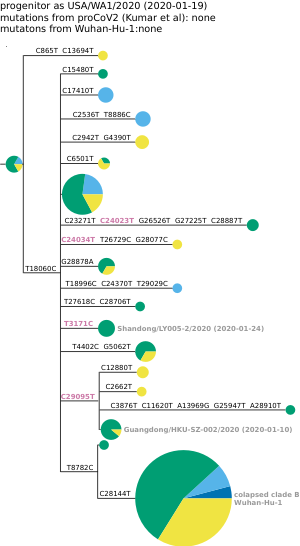

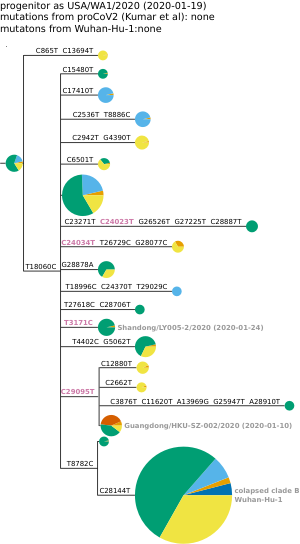

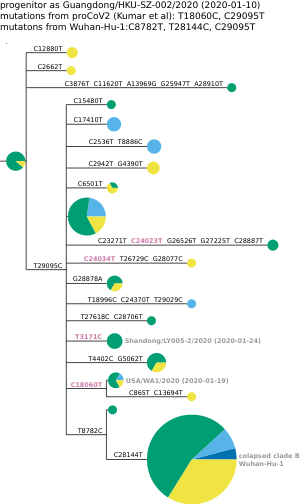

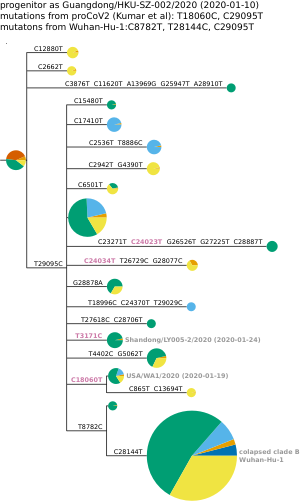

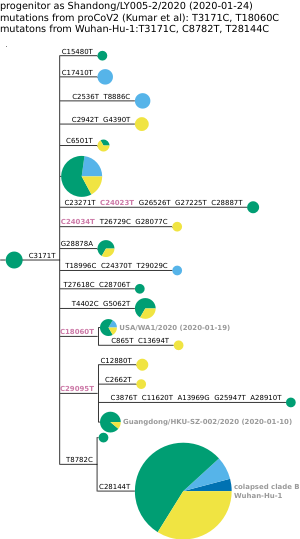

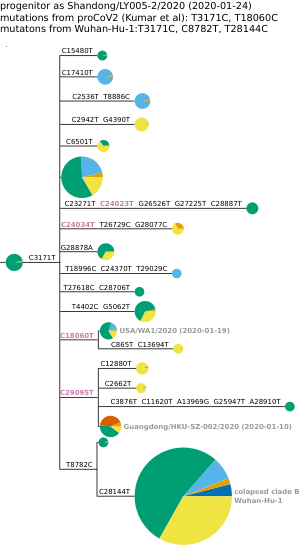

In [12]:
def get_PieChartFace(node_annotation, nodesizescale, locations):
    nstrains = node_annotation['nstrains']
    loc_sum = sum(node_annotation[loc] for loc in locations)
    assert numpy.allclose(nstrains, loc_sum, atol=1e-3), f"{nstrains=}\n{loc_sum=}\n{locations=}\n{node_annotation=}"
    radius = nodesizescale * math.sqrt(node_annotation['nstrains'])
    percents = []
    colors = []
    for loc, color in locations.items():
        percents.append(100 * node_annotation[loc] / nstrains)
        colors.append(color)
    return ete3.PieChartFace(percents=percents,
                             colors=colors,
                             width=radius,
                             height=radius,
                             #line_color='black',
                             )

def get_pretty_tree(treefile,
                    df,
                    subs_matrix,
                    progenitor,
                    to_outgroup_muts,
                    locations,
                    widthscale=1350,
                    heightscale=1,
                    nodesizescale=35,
                    label_nodes=False,
                    label_fontsize=25,
                    branch_linewidth=4,
                    mut_label_color='black',
                    mut_to_outgroup_label_color='#CC79A7',
                    collapse_below={'C28144T': ['colapsed clade B', 'Wuhan-Hu-1']},
                    node_label_color='#999999',
                    node_labels={},
                    title_fontsize=35,
                    ):
    """Returns `(tree, tree_style)`."""
    annotations = df.set_index('representative_strain').to_dict(orient='index')
    for loc in locations:
        if loc not in list(annotations.values())[0]:
            raise ValueError(f"annotations missing {loc}:\n{list(annotations.values())[0]}")
   
    t = ete3.Tree(treefile, format=1)

    ts = ete3.TreeStyle()
    ts.show_leaf_name = False  # add tip names manually
     
    nstyle_dict = {'hz_line_width': branch_linewidth,
                   'vt_line_width': branch_linewidth,
                   'hz_line_color': 'black',
                   'vt_line_color': 'black',
                   'size': 0}

    # label nodes
    for n in t.traverse():
        if n != t:
            subs = subs_matrix[(n.up.name, n.name)]
            icol = 0
            for sub in subs.split(', '):
                if sub:
                    to_outgroup = sub[1:] in to_outgroup_muts
                    n.add_face(ete3.TextFace(f"{sub}  ",
                                             fsize=label_fontsize,
                                             fgcolor=(mut_to_outgroup_label_color
                                                      if to_outgroup else
                                                      mut_label_color),
                                             bold=to_outgroup,
                                             ),
                               column=icol,
                               position='branch-top',
                               )
                    icol += 1
        nstyle = ete3.NodeStyle(**nstyle_dict)
        if n.is_leaf() or n.name == progenitor:
            n.add_face(get_PieChartFace(annotations[n.name], nodesizescale, locations),
                       column=0,
                       position='branch-right',
                       )
            if label_nodes:
                n.add_face(ete3.TextFace(annotations[n.name]['substitutions'],
                                         tight_text=True,
                                         fsize=labelfontsize,
                                         ),
                           column=0,
                           position='branch-right',
                           )
        n.set_style(nstyle)
        
    # set dummy node for root, this allows us to put
    # progenitor at base of root branch
    progenitor_n = t.search_nodes(name=progenitor)
    assert len(progenitor_n) == 1
    progenitor_n = progenitor_n[0]
    dummy_outgroup = progenitor_n.add_child(name='dummy',
                                            dist=1e-5)
    t.set_outgroup(dummy_outgroup)
    assert len(progenitor_n.children) == 1
    progenitor_child = progenitor_n.children[0]
    nstyle = ete3.NodeStyle(**nstyle_dict)
    progenitor_child.set_style(nstyle)
    if progenitor_n.faces:
        sub = subs_matrix[(progenitor_n.up.name, progenitor)]
        if sub:
            assert len(sub.split(',')) == 1
            sub_flipped = f"{sub[-1]}{sub[1: -1]}{sub[0]}"
            to_outgroup = sub_flipped[1:] in to_outgroup_muts
            progenitor_child.add_face(ete3.TextFace(f"{sub_flipped}  ",
                                                    fsize=label_fontsize,
                                                    fgcolor=(mut_to_outgroup_label_color
                                                             if to_outgroup else
                                                             mut_label_color),
                                                    bold=to_outgroup,
                                                    ),
                                      column=0,
                                      position='branch-top',
                                      )
        delattr(progenitor_n, '_faces')
    empty_nstyle = ete3.NodeStyle(hz_line_color='white',
                                  vt_line_color='white',
                                  size=0)
    dummy_outgroup.set_style(empty_nstyle)
    dummy_outgroup.up.set_style(empty_nstyle)
    progenitor_n.add_face(get_PieChartFace(annotations[progenitor], nodesizescale, locations),
                          column=0,
                          position='branch-right',
                          )

    t.ladderize()
    
    # collapse tree at indicated nodes
    for below_subs, txt in collapse_below.items():
        collapse_n = [n for n in t.traverse() if n.name and n.up and n.up.name and
                      n.name != 'dummy' and subs_matrix[(n.up.name, n.name)] == below_subs]
        if len(collapse_n) > 1:
            raise ValueError(f"more than one node to collapse for {below_subs}")
        elif len(collapse_n) == 0:
            raise ValueError(f"no nodes to collapse for {below_subs}")
        collapse_n = collapse_n[0]
        collapse_nstrains = 0
        collapse_annotations = {key: 0 for key in ['nstrains', *locations]}
        for n in [collapse_n] + collapse_n.get_descendants():
            if n.is_leaf():
                collapse_annotations['nstrains'] += annotations[n.name]['nstrains']
                for location in locations:
                    collapse_annotations[location] += annotations[n.name][location]
            if n != collapse_n:
                n.detach()
        nstyle = ete3.NodeStyle(**nstyle_dict)
        collapse_n.set_style(nstyle)
        collapse_n.add_face(get_PieChartFace(collapse_annotations, nodesizescale, locations),
                            column=0,
                            position='branch-right',
                            )
        for face_txt in txt:
            collapse_n.add_face(ete3.TextFace(f" {face_txt}",
                                              fsize=label_fontsize,
                                              fgcolor=node_label_color,
                                              bold=True,
                                              ),
                                column=1,
                                position='branch-right',
                                )
    
    # label specified non-progenitor nodes
    for name, labels in node_labels.items():
        if name == progenitor:
            continue
        n = t.search_nodes(name=name)
        assert len(n) == 1
        n = n[0]
        for face_txt in labels[: 1]:
            n.add_face(ete3.TextFace(f" {face_txt}",
                                     fsize=label_fontsize,
                                     fgcolor=node_label_color,
                                     bold=True,
                                     ),
                       column=1,
                       position='branch-right',
                       )
            
    # add title
    if progenitor in node_labels:
        title_labels = node_labels[progenitor]
    else:
        title_labels = [progenitor]
    for i, face_txt in enumerate(title_labels):
        if i == 0:
            prefix = 'progenitor as '
        else:
            prefix = ''
        ts.title.add_face(ete3.TextFace(prefix + face_txt,
                                        fsize=title_fontsize,
                                        fgcolor='black'),
                          column=0,
                          )
    ts.title.add_face(ete3.TextFace('', fsize=title_fontsize),
                      column=0)
    
    ts.show_scale = False
    height = t.get_farthest_node()[1]
    ts.scale = widthscale / height
    ts.branch_vertical_margin = heightscale
    
    return t, ts

assert len(progenitors) == len(tree_files)
for outgroup, (progenitor, tree_file) in itertools.product(outgroups,
                                                           zip(progenitors, tree_files)
                                                           ):
    if outgroup != 'RaTG13':
        continue  # debugging
    t, ts = get_pretty_tree(tree_file,
                            df=all_df_cat_cols,
                            subs_matrix=subs_matrices[progenitor],
                            progenitor=progenitor,
                            to_outgroup_muts=subs_to_outgroup[outgroup],
                            node_labels=node_labels,
                            locations=cat_colors,
                            )
    display(t.render('%%inline', tree_style=ts, w=300))
    t_deleted, ts_deleted = get_pretty_tree(
                            tree_file,
                            df=all_plus_deleted_df,
                            subs_matrix=subs_matrices[progenitor],
                            progenitor=progenitor,
                            to_outgroup_muts=subs_to_outgroup[outgroup],
                            node_labels=node_labels,
                            locations=subcat_colors,
                            )
    display(t_deleted.render('%%inline', tree_style=ts_deleted, w=300))